In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image

## Workflow
This analysis used customer transaction data to  
      1. Assign **Recency, Frequency, and Monetary (RFM)** scores to each customer_id  
      2. Segment customer into k group based on their RFM score using **K-mean clustering**  
      3. Simulate additional transaction data assuming that **loyalty discounts** are given to top clusters  
      4. Use **Redression Discontinuity Design (RDD)** to determine casual effect of the loyalty discounts  

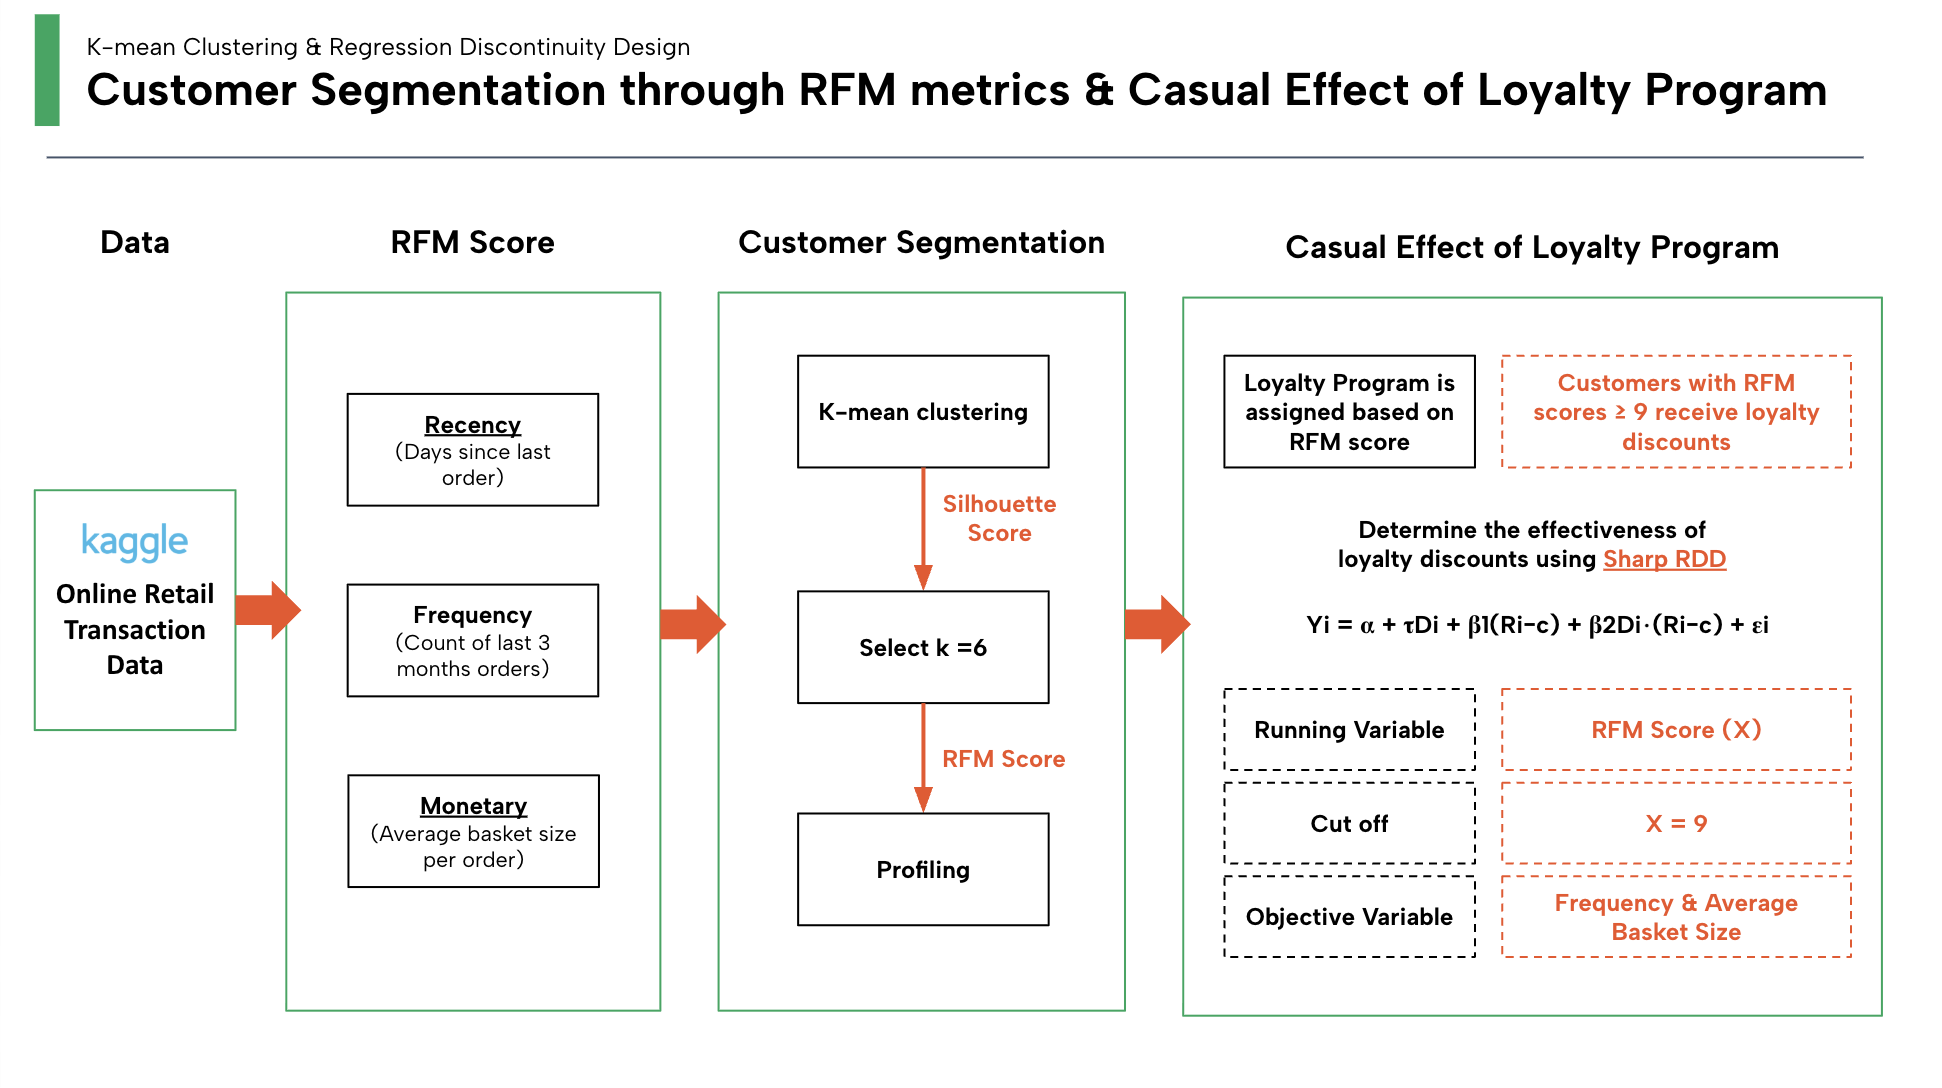

In [2]:
Image("workflow.png", width=1000, height=300)

## Upload Data
- Datasource: https://www.kaggle.com/datasets/mathchi/online-retail-ii-data-set-from-ml-repository/versions/1/data

In [3]:
df1 = pd.read_csv("online_retail_2009_2010.csv")
df2 = pd.read_csv("online_retail_2010_2011.csv")

df = pd.concat([df1, df2], axis=0)
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/09 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/09 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/09 7:45,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/11 12:50,4.95,12680.0,France


In [4]:
df.shape

(1067371, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1067371 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 73.3+ MB


In [6]:
df['date'] = pd.to_datetime(df['InvoiceDate'], format='%m/%d/%y %H:%M')

In [7]:
df['date'].max()

Timestamp('2011-12-09 12:50:00')

In [8]:
# Reference date 
ref_date = pd.to_datetime('2011-12-10')

# Calculate time difference
df['days_since_ordered'] = (ref_date - df['date']).dt.days 
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,date,days_since_ordered
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/09 7:45,6.95,13085.0,United Kingdom,2009-12-01 07:45:00,738
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom,2009-12-01 07:45:00,738
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom,2009-12-01 07:45:00,738
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/09 7:45,2.10,13085.0,United Kingdom,2009-12-01 07:45:00,738
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/09 7:45,1.25,13085.0,United Kingdom,2009-12-01 07:45:00,738
...,...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France,2011-12-09 12:50:00,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France,2011-12-09 12:50:00,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France,2011-12-09 12:50:00,0
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/11 12:50,4.95,12680.0,France,2011-12-09 12:50:00,0


In [9]:
df['basket_size'] = df['Price'] * df['Quantity']
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,date,days_since_ordered,basket_size
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/09 7:45,6.95,13085.0,United Kingdom,2009-12-01 07:45:00,738,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom,2009-12-01 07:45:00,738,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/09 7:45,6.75,13085.0,United Kingdom,2009-12-01 07:45:00,738,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/09 7:45,2.10,13085.0,United Kingdom,2009-12-01 07:45:00,738,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/09 7:45,1.25,13085.0,United Kingdom,2009-12-01 07:45:00,738,30.00
...,...,...,...,...,...,...,...,...,...,...,...
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/11 12:50,2.10,12680.0,France,2011-12-09 12:50:00,0,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/11 12:50,4.15,12680.0,France,2011-12-09 12:50:00,0,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/11 12:50,4.15,12680.0,France,2011-12-09 12:50:00,0,16.60
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,12/9/11 12:50,4.95,12680.0,France,2011-12-09 12:50:00,0,14.85


## Recency, Frequency, Monetization
- create columns for RFM
- convert each column into a quantile score (1-4)

In [10]:
# Group by 'City' and aggregate
rfm_df = df.groupby('Customer ID').agg({
    'basket_size': 'mean',
    'days_since_ordered': 'max',
    'Invoice': 'count'
}).reset_index()

rfm_df

,Customer ID,basket_size,days_since_ordered,Invoice
0,12346.0,-1.347500,725,48
1,12347.0,22.266087,404,253
2,12348.0,39.596078,438,51
3,12349.0,24.469667,735,180
4,12350.0,19.670588,310,17
...,...,...,...,...
5937,18283.0,2.775507,658,986
5938,18284.0,15.057931,431,29
5939,18285.0,35.583333,660,12
5940,18286.0,16.977571,723,70


In [11]:
# Assign quartiles (1 = lowest, 4 = highest)
rfm_df['recency_q'] = pd.qcut(rfm_df['days_since_ordered'], q=4, labels=[1, 2, 3, 4])
rfm_df['recency_q'] = rfm_df['recency_q'].astype(int)

rfm_df['frequency_q'] = pd.qcut(rfm_df['Invoice'], q=4, labels=[1, 2, 3, 4])
rfm_df['frequency_q'] = rfm_df['frequency_q'].astype(int)

rfm_df['monetary_q'] = pd.qcut(rfm_df['basket_size'], q=4, labels=[1, 2, 3, 4])
rfm_df['monetary_q'] = rfm_df['monetary_q'].astype(int)

rfm_df

,Customer ID,basket_size,days_since_ordered,Invoice,recency_q,frequency_q,monetary_q
0,12346.0,-1.347500,725,48,4,2,1
1,12347.0,22.266087,404,253,2,4,3
2,12348.0,39.596078,438,51,2,2,4
3,12349.0,24.469667,735,180,4,4,4
4,12350.0,19.670588,310,17,1,1,3
...,...,...,...,...,...,...,...
5937,18283.0,2.775507,658,986,3,4,1
5938,18284.0,15.057931,431,29,2,2,2
5939,18285.0,35.583333,660,12,3,1,4
5940,18286.0,16.977571,723,70,4,3,3


## K-mean clustering

### Pick the best number of cluster based on silhouette_score

- k=6 has silhouette_score closest to 1

In [12]:
X = rfm_df[['recency_q','frequency_q','monetary_q']]
X

,recency_q,frequency_q,monetary_q
0,4,2,1
1,2,4,3
2,2,2,4
3,4,4,4
4,1,1,3
...,...,...,...
5937,3,4,1
5938,2,2,2
5939,3,1,4
5940,4,3,3


In [13]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

best_score = -1
best_k = None
best_model = None

# Loop over k from 3 to 12
for k in range(3, 13):
    kmeans = KMeans(n_clusters=k, n_init=50, max_iter=100, random_state=410014)
    labels = kmeans.fit_predict(X)

    score = silhouette_score(X, labels)
    print(f"K={k}, Silhouette Score={score:.4f}")

    if score > best_score:
        best_score = score
        best_k = k
        best_model = kmeans

print(f"\nBest K: {best_k} with Silhouette Score: {best_score:.4f}")

K=3, Silhouette Score=0.3061
K=4, Silhouette Score=0.3206
K=5, Silhouette Score=0.3390
K=6, Silhouette Score=0.3661
K=7, Silhouette Score=0.3845
K=8, Silhouette Score=0.4053
K=9, Silhouette Score=0.3880
K=10, Silhouette Score=0.3747
K=11, Silhouette Score=0.3716
K=12, Silhouette Score=0.3672

Best K: 8 with Silhouette Score: 0.4053


#### Run K-mean clustering with k = 6

In [14]:
from sklearn.cluster import KMeans

# colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

k = 6
kmeansModel = KMeans(n_clusters=k, n_init=50, max_iter=100, random_state=410014)
labels = kmeansModel.fit_predict(X)
labels

array([2, 0, 5, ..., 1, 4, 4], dtype=int32)

/var/folders/zk/r678267s275b0vt8dj9q7hzc0000gn/T/ipykernel_32709/509463217.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab10', k)  # or 'Set1', 'Dark2', etc.


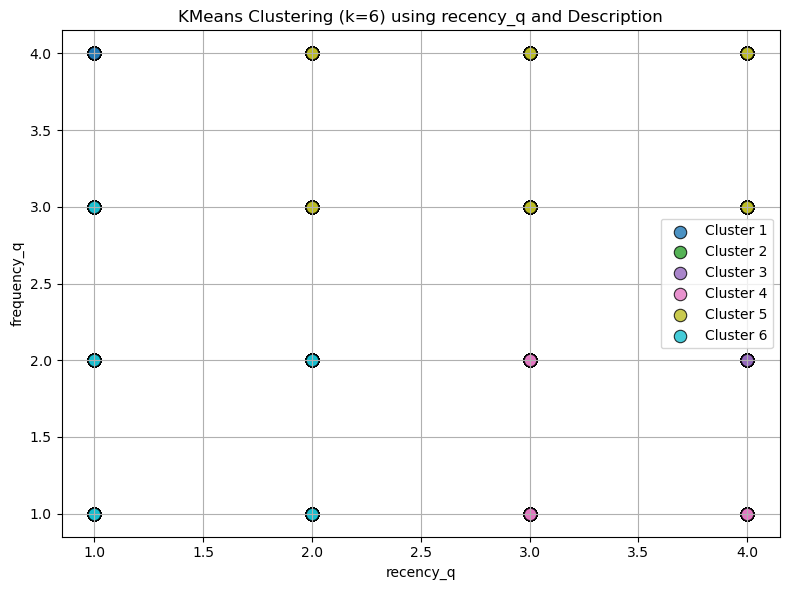

In [15]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Use a color map with high contrast
cmap = cm.get_cmap('tab10', k)  # or 'Set1', 'Dark2', etc.

plt.figure(figsize=(8, 6))
for cluster in range(k):
    cluster_mask = labels == cluster
    plt.scatter(
        X.iloc[cluster_mask, 0],
        X.iloc[cluster_mask, 1],
        color=cmap(cluster),
        label=f'Cluster {cluster+1}',
        s=80, alpha=0.8, edgecolor='black', linewidth=0.8
    )

plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])
plt.title(f'KMeans Clustering (k={k}) using {X.columns[0]} and {df.columns[2]}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
X['cluster'] = labels
X

/var/folders/zk/r678267s275b0vt8dj9q7hzc0000gn/T/ipykernel_32709/555771858.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = labels


,recency_q,frequency_q,monetary_q,cluster
0,4,2,1,2
1,2,4,3,0
2,2,2,4,5
3,4,4,4,4
4,1,1,3,5
...,...,...,...,...
5937,3,4,1,2
5938,2,2,2,3
5939,3,1,4,1
5940,4,3,3,4


In [17]:
cluster_means = X.groupby('cluster').mean().round(0)

In [18]:
cluster_means

,recency_q,frequency_q,monetary_q
cluster,,,
0,2.0,3.0,2.0
1,3.0,1.0,3.0
2,4.0,4.0,1.0
3,2.0,2.0,2.0
4,3.0,4.0,4.0
5,1.0,1.0,4.0


## Customer Profiling Based on K-mean Clusters
- Top customers are:
    - Cluster 2: Engaged Segment (441)
    - Cluster 4: High-value Segment (344)

| Cluster | Recency (Q) | Frequency (Q) | Monetary (Q) | Interpretation                                                                                                         |
| ------- | ----------- | ------------- | ------------ | ---------------------------------------------------------------------------------------------------------------------- |
| 0       | 2.0         | 3.0           | 2.0          | **Moderate recency & frequency, low-moderate spend**: regular but low-value shoppers.                        |
| 1       | 3.0         | 1.0           | 3.0          | **Recent orders & decent spend, but low frequency**: newer or occasional high-value customers.               |
| 2       | 4.0         | 4.0           | 1.0          | **Very engaged (recent & frequent), but low spend**: potential for upsell or promo targeting. (**top customers**)                         |
| 3       | 2.0         | 2.0           | 2.0          | **Average across the board**: general segment, not highly differentiated.                                             |
| 4       | 3.0         | 4.0           | 4.0          | **High-value segment**: recent, frequent, and big spenders (**top customers**)                                  |
| 5       | 1.0         | 1.0           | 4.0          | **Lapsed high spenders**: haven't ordered often, but used to spend a lot (could be reactivation targets.) |


## Simulation: Offer a "Loyalty Program" 
- improve frequency and monetary value of our "loyal customers"
- define "loyal customer" as people with high RFM value (cluster 2 and 4)
- **objective: determine the casual effect of the loyalty program on frequency (count of invoices)**

In [19]:
rfm_df['cluster'] = labels

In [20]:
treatment_group = rfm_df[(rfm_df['cluster'] == 2) | (rfm_df['cluster'] == 4)].reset_index(drop = True)
treatment_group

,Customer ID,basket_size,days_since_ordered,Invoice,recency_q,frequency_q,monetary_q,cluster
0,12346.0,-1.347500,725,48,4,2,1,2
1,12349.0,24.469667,735,180,4,4,4,4
2,12356.0,44.571189,424,143,2,3,4,4
3,12357.0,61.782635,388,296,2,4,4,4
4,12358.0,50.481429,731,77,4,3,4,4
...,...,...,...,...,...,...,...,...
1968,18272.0,18.738491,645,232,3,4,3,4
1969,18276.0,16.370404,729,99,4,3,2,2
1970,18283.0,2.775507,658,986,3,4,1,2
1971,18286.0,16.977571,723,70,4,3,3,4


In [21]:
treatment_customer_id = treatment_group['Customer ID'].unique()
treatment_customer_id

array([12346., 12349., 12356., ..., 18283., 18286., 18287.])

In [22]:
customer_id = rfm_df['Customer ID'].unique()

In [23]:
# Number of rows to simulate per customer
n_rows_per_customer = 1

# Expand customer list
customer_column = np.repeat(customer_id, n_rows_per_customer)

# Random basket sizes (e.g., between $10 and $500)
basket_size = np.random.uniform(0, 4000, size=len(customer_column))

# Random days since last order (e.g., 1 to 90 days)
days_since_ordered = np.random.randint(0, 91, size=len(customer_column))

# Random Invoice numbers (could be strings or integers)
# invoice = np.random.randint(0, 200, size=len(customer_column))

# Generate invoice count with different logic
invoice = [
    np.random.randint(50, 200) if customer in treatment_customer_id
    else np.random.randint(0, 200)
    for customer in customer_column
]

# Put into DataFrame
post_df = pd.DataFrame({
    'customer_id': customer_column,
    'basket_size': basket_size,
    'days_since_ordered': days_since_ordered,
    'Invoice': invoice
})

# # Combine into a DataFrame
# post_df = pd.DataFrame({
#     'customer_id': customer_column,
#     'basket_size': basket_size,
#     'days_since_ordered': days_since_ordered,
#     'Invoice': invoice
# })

post_df['basket_size'] = post_df['basket_size'].round(2)

post_df.head(10)

,customer_id,basket_size,days_since_ordered,Invoice
0,12346.0,1536.74,51,124
1,12347.0,1354.15,9,10
2,12348.0,1493.73,23,153
3,12349.0,474.72,32,86
4,12350.0,3454.59,83,80
5,12351.0,3278.87,5,37
6,12352.0,3216.99,36,85
7,12353.0,1305.34,12,155
8,12354.0,2076.88,88,94
9,12355.0,1931.24,8,79


In [24]:
mask = (
    (post_df['Invoice'] == 0) |
    (post_df['days_since_ordered'] == 0) |
    (post_df['basket_size'] == 0)
)

post_df.loc[mask, ['Invoice', 'days_since_ordered', 'basket_size']] = 0

In [25]:
post_df['treatment'] = post_df['customer_id'].isin(treatment_customer_id).astype(int)

In [26]:
post_df

,customer_id,basket_size,days_since_ordered,Invoice,treatment
0,12346.0,1536.74,51,124,1
1,12347.0,1354.15,9,10,0
2,12348.0,1493.73,23,153,0
3,12349.0,474.72,32,86,1
4,12350.0,3454.59,83,80,0
...,...,...,...,...,...
5937,18283.0,692.63,46,93,1
5938,18284.0,3876.10,43,138,0
5939,18285.0,1643.49,55,182,0
5940,18286.0,2622.81,13,122,1


### RDD Analysis

In [27]:
post_df['cluster'] = labels
post_df

cluster_map = {
    0: 7.0,
    1: 7.0,
    2: 9.0,
    3: 6.0,
    4: 11.0,
    5: 6.0
}

post_df['running_variable'] = post_df['cluster'].map(cluster_map)
post_df

,customer_id,basket_size,days_since_ordered,Invoice,treatment,cluster,running_variable
0,12346.0,1536.74,51,124,1,2,9.0
1,12347.0,1354.15,9,10,0,0,7.0
2,12348.0,1493.73,23,153,0,5,6.0
3,12349.0,474.72,32,86,1,4,11.0
4,12350.0,3454.59,83,80,0,5,6.0
...,...,...,...,...,...,...,...
5937,18283.0,692.63,46,93,1,2,9.0
5938,18284.0,3876.10,43,138,0,3,6.0
5939,18285.0,1643.49,55,182,0,1,7.0
5940,18286.0,2622.81,13,122,1,4,11.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


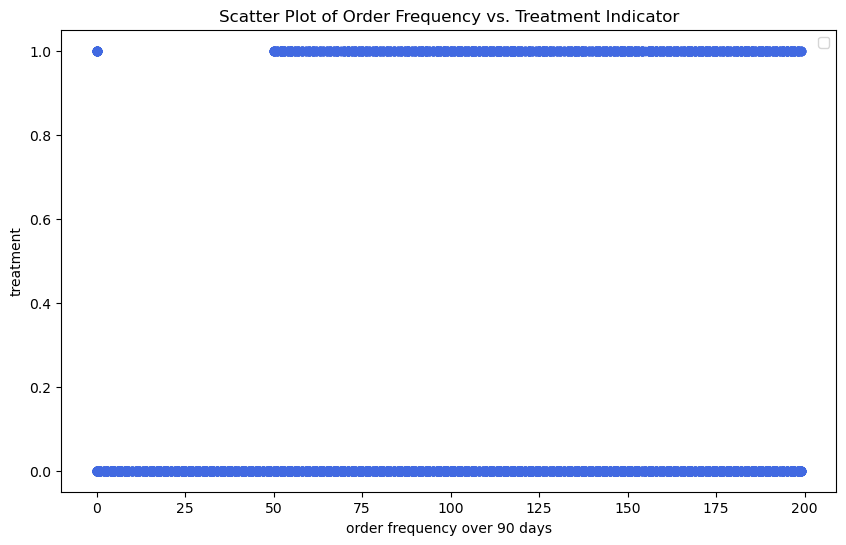

In [28]:
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(post_df["Invoice"], post_df["treatment"], alpha=0.6, color="royalblue")

# Highlight cutoff
# plt.axvline(x=4.05, color='red', linestyle='--', label="Cutoff at 4.05")
plt.xlabel("order frequency over 90 days")
plt.ylabel("treatment")
plt.title("Scatter Plot of Order Frequency vs. Treatment Indicator")
plt.legend()
plt.show()

In [29]:
cluster_means.sum(axis = 1)

cluster
0     7.0
1     7.0
2     9.0
3     6.0
4    11.0
5     6.0
dtype: float64

## RDD Result:
#### Yi​ = α + τDi ​+ β1​(Ri​−c) + β2​Di​⋅(Ri​−c) + εi
#### Yi​ = 98.5 + 22.2 * Di ​+ 0.4147​(Ri​−9) + 2.2214 * ​Di​⋅(Ri​−9) + εi
- The treatment effect (τ) is 22.2 meaning, on average, **treatment group order 22.2 more times than control (higher frequency).**  
- The slopes of the relationship between treatment and control on count of invoices are not statistically significant  
- Loyalty discount **doesn't have stat-sig effect on Recency and Monetary.** which allign with how the data is simulated

In [30]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define cutoff threshold
cutoff = 9

# Center the running variable at the cutoff
post_df['rating_centered'] = post_df['running_variable'] - cutoff

# Create interaction term (capture the relationship between X and Y
post_df['interaction'] = post_df['treatment'] * post_df['rating_centered']
# post_df['interaction_powered'] = post_df['treatment'] * (post_df['rating_centered']**2)

# RDD Regression matching the equation
# rdd_model = smf.ols("Invoice ~ treatment + interaction + interaction_power", data=post_df).fit()
rdd_model = smf.ols("Invoice ~ treatment + rating_centered + interaction", data=post_df).fit()

# Print summary
print(rdd_model.summary())

                            OLS Regression Results                            
Dep. Variable:                Invoice   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     97.64
Date:                Fri, 27 Jun 2025   Prob (F-statistic):           1.10e-61
Time:                        13:30:24   Log-Likelihood:                -32137.
No. Observations:                5942   AIC:                         6.428e+04
Df Residuals:                    5938   BIC:                         6.431e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          99.0000      4.535     

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define cutoff threshold
cutoff = 9

# Center the running variable at the cutoff
post_df['rating_centered'] = post_df['running_variable'] - cutoff

# Create interaction term (capture the relationship between X and Y
post_df['interaction'] = post_df['treatment'] * post_df['rating_centered']
# post_df['interaction_powered'] = post_df['treatment'] * (post_df['rating_centered']**2)

# RDD Regression matching the equation
# rdd_model = smf.ols("Invoice ~ treatment + interaction + interaction_power", data=post_df).fit()
rdd_model = smf.ols("basket_size ~ treatment + rating_centered + interaction", data=post_df).fit()

# Print summary
print(rdd_model.summary())

                            OLS Regression Results                            
Dep. Variable:            basket_size   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.257
Date:                Fri, 27 Jun 2025   Prob (F-statistic):             0.0797
Time:                        13:30:24   Log-Likelihood:                -50373.
No. Observations:                5942   AIC:                         1.008e+05
Df Residuals:                    5938   BIC:                         1.008e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2010.7231     97.575     

In [32]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define cutoff threshold
cutoff = 9

# Center the running variable at the cutoff
post_df['rating_centered'] = post_df['running_variable'] - cutoff

# Create interaction term (capture the relationship between X and Y
post_df['interaction'] = post_df['treatment'] * post_df['rating_centered']
# post_df['interaction_powered'] = post_df['treatment'] * (post_df['rating_centered']**2)

# RDD Regression matching the equation
# rdd_model = smf.ols("Invoice ~ treatment + interaction + interaction_power", data=post_df).fit()
rdd_model = smf.ols("days_since_ordered ~ treatment + rating_centered + interaction", data=post_df).fit()

# Print summary
print(rdd_model.summary())

                            OLS Regression Results                            
Dep. Variable:     days_since_ordered   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8154
Date:                Fri, 27 Jun 2025   Prob (F-statistic):              0.485
Time:                        13:30:24   Log-Likelihood:                -27915.
No. Observations:                5942   AIC:                         5.584e+04
Df Residuals:                    5938   BIC:                         5.586e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          42.8333      2.228     